## Introduction

The following examples shows how to retrieve Kimber dust soiling loss using the Solcast Python SDK and visualize the data.

- Live estimated actuals (near real-time and past 7 days)
- Forecast (near real-time and up to 7 days ahead)
- Historic (date-ranged queries; up to 31 days per request)

All requests here use the SDK, returning convenient response objects that can be converted to pandas DataFrames.

## Model Background

The Kimber model calculates the fraction of daily energy lost to soiling by assuming a linearly increasing soiling loss until a cleaning event resets the loss to zero. The cleaning event occurs whenever rainfall in a rolling 24-hour window exceeds a user-defined threshold or when manual wash dates are supplied. A grace period parameter allows for soiling to be 0 for some time after a cleaning event (presuming that soil is wet enough to prevent dust formation). Users of the Solcast soiling API can configure the soiling loss rate, rainfall cleaning threshold, and manual washing schedules. Solcast supplies the precipitation inputs so the model can be run without sourcing external environmental data. The output is a soiling loss fraction suitable for applying directly to PV forecasting or yield models. See [Kimber et al., 2006 (IEEE WCPEC)](http://dx.doi.org/10.1109/WCPEC.2006.279690) for the original model discussion.

## Prerequisites

### Dependencies
- Solcast API key with access to soiling endpoints.
- Python with `solcast`, `pandas`, `matplotlib` installed.
- Set environment variable `SOLCAST_API_KEY`.

In [1]:
import os

from solcast import live as solcast_live
from solcast import forecast as solcast_forecast
from solcast import historic as solcast_historic
from solcast.unmetered_locations import UNMETERED_LOCATIONS

### Configurations
Set API base and key. Default base: https://dev-api.solcast.com.au

In [2]:
API_BASE = os.environ.get("SOLCAST_API_BASE", "https://api.solcast.com.au")

API_KEY = os.environ.get("SOLCAST_API_KEY", "")

# Using unmetered location metadata to keep examples consistent without sharing site details
sydney = UNMETERED_LOCATIONS["Sydney Opera House"]

---

## Live Estimated Actuals

Endpoint: /data/live/soiling/kimber

### SDK Parameters

The following SDK function will be used:

In [3]:
help(solcast_live.soiling_kimber)

Help on function soiling_kimber in module solcast.live:

soiling_kimber(latitude: float, longitude: float, base_url='https://api.solcast.com.au', **kwargs) -> solcast.api.PandafiableResponse
    Get hourly soiling loss using the Kimber model.

    Returns a time series of estimated cumulative soiling / cleanliness state for the
    requested location based on Pvlib's Kimber model.

    Args:
        latitude: Decimal degrees, between -90 and 90 (north positive).
        longitude: Decimal degrees, between -180 and 180 (east positive).
        **kwargs: Additional query parameters accepted by the endpoint (e.g. depo_veloc_pm10, initial_soiling).

    Returns:
        PandafiableResponse: Response object; call `.to_pandas()` for a DataFrame.

    See https://docs.solcast.com.au/ for full parameter details.



### Accessing Additional Parameters

For this example, we will provide additional parameters as specified by the Solcast API docs. Following is a brief summary:

- latitude/longitude (EPSG:4326)
- period: PT5M | PT10M | PT15M | PT20M | PT30M | PT60M (default PT30M)
- cleaning_threshold: rainfall (mm) in a rolling 24h window to clean (default 1.0)
- soiling_loss_rate: Fraction of additional energy loss due to an additional day of soiling
- max_soiling: Maximum fraction of energy lost due to soiling. Soiling will build up until this value.
- initial_soiling: 0 to 1 (fraction at period start)
- manual_wash_dates: list of ISO dates when cleaning occurs
- time_zone: `utc` | `longitudinal` | `offset`
- format: `json` | `csv`

Tip: Use the SDK’s `.to_pandas()` for quick plotting.

In [4]:
kimber_live_params = {
    "latitude": sydney.get("latitude"),
    "longitude": sydney.get("longitude"),
    "period": "PT30M",
    "hours": 48,
    "initial_soiling": 0.1,
    "manual_wash_dates": "[2022-10-26,2025-11-14,2025-11-26]",
}
print(kimber_live_params)

kl_resp = solcast_live.soiling_kimber(base_url=API_BASE, api_key=API_KEY, **kimber_live_params)
kl_resp

{'latitude': -33.856784, 'longitude': 151.215297, 'period': 'PT30M', 'hours': 48, 'initial_soiling': 0.1, 'manual_wash_dates': '[2022-10-26,2025-11-14,2025-11-26]'}


status code=200, url=https://api.solcast.com.au/data/live/soiling/kimber?latitude=-33.856784&longitude=151.215297&format=json&period=PT30M&hours=48&initial_soiling=0.1&manual_wash_dates=%5B2022-10-26%2C2025-11-14%2C2025-11-26%5D, method=GET

In [5]:
kl_df = kl_resp.to_pandas()
kl_df.index = kl_df.index.tz_convert('Australia/Sydney')  # type: ignore
kl_df.head(10)

,kimber_loss_fraction
period_end,
2025-12-26 15:00:00+11:00,0.1030
2025-12-26 14:30:00+11:00,0.1029
2025-12-26 14:00:00+11:00,0.1029
2025-12-26 13:30:00+11:00,0.1029
2025-12-26 13:00:00+11:00,0.1028
2025-12-26 12:30:00+11:00,0.1028
2025-12-26 12:00:00+11:00,0.1028
2025-12-26 11:30:00+11:00,0.1027
2025-12-26 11:00:00+11:00,0.1027


<Axes: xlabel='period_end'>

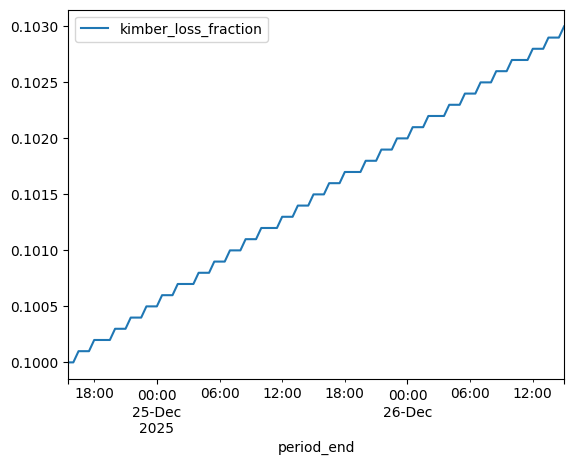

In [6]:
kl_df.plot()

---

## Forecast
Endpoint: /data/forecast/soiling/kimber

In [7]:
kimber_fc_params = {
    "latitude": sydney.get("latitude"),
    "longitude": sydney.get("longitude"),
    "hours": 120,
    "period": "PT30M",
    "initial_soiling": 0.3,
    "max_soiling": 0.4,
    "manual_wash_dates": "[2022-10-26,2025-11-14,2025-11-26]",
    "grace_period": 1,
    "cleaning_threshold": 6.0,
}
print(kimber_fc_params)

kf_resp = solcast_forecast.soiling_kimber(base_url=API_BASE, api_key=API_KEY, **kimber_fc_params)
kf_resp

{'latitude': -33.856784, 'longitude': 151.215297, 'hours': 120, 'period': 'PT30M', 'initial_soiling': 0.3, 'max_soiling': 0.4, 'manual_wash_dates': '[2022-10-26,2025-11-14,2025-11-26]', 'grace_period': 1, 'cleaning_threshold': 6.0}


status code=200, url=https://api.solcast.com.au/data/forecast/soiling/kimber?latitude=-33.856784&longitude=151.215297&format=json&hours=120&period=PT30M&initial_soiling=0.3&max_soiling=0.4&manual_wash_dates=%5B2022-10-26%2C2025-11-14%2C2025-11-26%5D&grace_period=1&cleaning_threshold=6.0, method=GET

In [8]:
kf_df = kf_resp.to_pandas()
kf_df = kf_df.tz_convert("Australia/Sydney")
kf_df.head(10)

,kimber_loss_fraction
period_end,
2025-12-26 15:30:00+11:00,0.3000
2025-12-26 16:00:00+11:00,0.3000
2025-12-26 16:30:00+11:00,0.3001
2025-12-26 17:00:00+11:00,0.3001
2025-12-26 17:30:00+11:00,0.3001
2025-12-26 18:00:00+11:00,0.3002
2025-12-26 18:30:00+11:00,0.3002
2025-12-26 19:00:00+11:00,0.3002
2025-12-26 19:30:00+11:00,0.3002


<Axes: xlabel='period_end'>

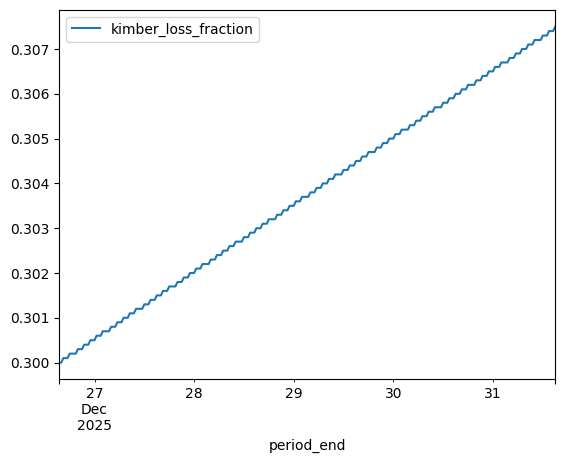

In [9]:
kf_df.plot()

---

## Historic

Endpoint: /data/historic/soiling/kimber

In [10]:
kimber_hist_params = {
    "latitude": sydney.get("latitude"),
    "longitude": sydney.get("longitude"),
    "period": "PT30M",
    "start": "2025-10-25T14:45:00Z",
    "duration": "P30D",
    "initial_soiling": 0.1,
    "cleaning_threshold": 6.0,
    "grace_period": 0,
    "manual_wash_dates": "[2025-11-03]",
}
print(kimber_hist_params)

kh_resp = solcast_historic.soiling_kimber(base_url=API_BASE, api_key=API_KEY, **kimber_hist_params)
kh_resp

{'latitude': -33.856784, 'longitude': 151.215297, 'period': 'PT30M', 'start': '2025-10-25T14:45:00Z', 'duration': 'P30D', 'initial_soiling': 0.1, 'cleaning_threshold': 6.0, 'grace_period': 0, 'manual_wash_dates': '[2025-11-03]'}


status code=200, url=https://api.solcast.com.au/data/historic/soiling/kimber?latitude=-33.856784&longitude=151.215297&start=2025-10-25T14%3A45%3A00Z&format=json&period=PT30M&initial_soiling=0.1&cleaning_threshold=6.0&grace_period=0&manual_wash_dates=%5B2025-11-03%5D&duration=P30D, method=GET

In [11]:
kh_df = kh_resp.to_pandas()
kh_df = kh_df.tz_convert('Australia/Sydney')
kh_df.head(10)

,kimber_loss_fraction
period_end,
2025-10-26 02:00:00+11:00,0.1000
2025-10-26 02:30:00+11:00,0.1001
2025-10-26 03:00:00+11:00,0.1001
2025-10-26 03:30:00+11:00,0.1001
2025-10-26 04:00:00+11:00,0.1002
2025-10-26 04:30:00+11:00,0.1002
2025-10-26 05:00:00+11:00,0.1002
2025-10-26 05:30:00+11:00,0.1002
2025-10-26 06:00:00+11:00,0.1003


<Axes: xlabel='period_end'>

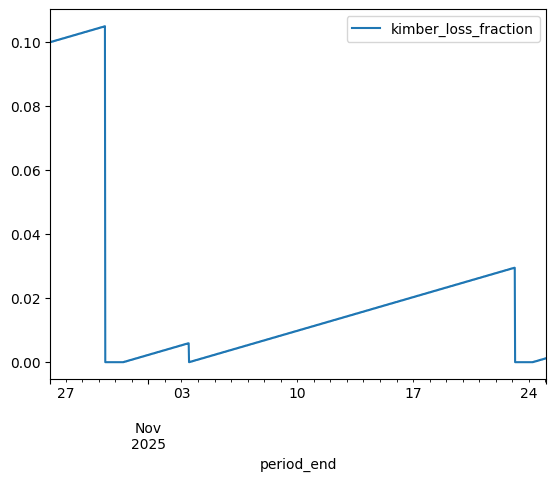

In [12]:
kh_df.plot()

## Troubleshooting
- 401/403: Ensure API key is valid and access includes soiling endpoints.
- Empty payloads: Reduce `hours` or adjust `start`/`duration`.
- Parsing mismatch: Inspect `.to_dict()` from the SDK response and adjust DataFrame parsing.

Tip: For larger historical ranges, paginate (max 31 days per request) and concatenate in pandas.